# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  1111k      0  0:02:29  0:02:29 --:--:-- 1315k0     0  1199k      0  0:02:18  0:00:54  0:01:24 1191k02:25  0:01:51  0:00:34 1308k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

# cifar10_dir = '../data/cifar10/cifar-10-batches-py'
cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_val, Y_val, X_test, y_test = load_CIFAR10(cifar10_dir)

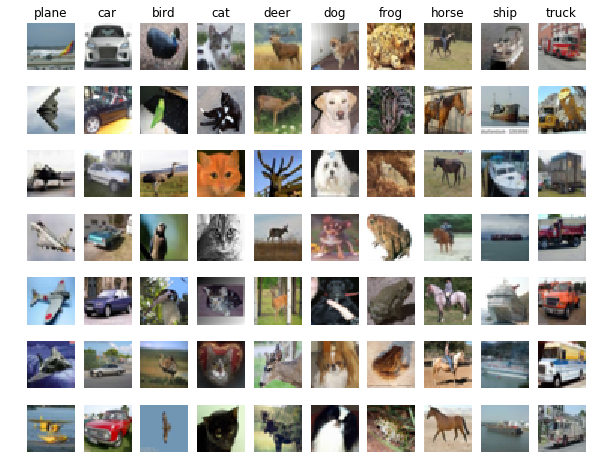

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Значительно большая глубина, прокидывание результатов слоев, batch normalisation, ... 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [5]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer", dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [23]:
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers.dnn import batch_norm_dnn as batch_norm

def get_residual(in_l, n):
    stack1 = batch_norm(ConvLayer(in_l, n, 3, pad='same')) # сверточный слой
    stack2 = batch_norm(ConvLayer(stack1, n, 3, pad='same')) # сверточный слой
    layer = lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack1, stack2]))
    
    return layer

def gen_proto_layer(in_l, n, num_residual=5):
    for i in range(num_residual):
        in_l = get_residual(in_l, n)
    
    return in_l

In [48]:
from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPoolLayer

net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

n0 = 64

l1 = gen_proto_layer(net, n0)
print("l1", l1.output_shape)
l2 = gen_proto_layer(l1, n0 * 2)
print("l2", l2.output_shape)

net = MaxPoolLayer(l2, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)

l3 = gen_proto_layer(net, n0 * 4)
print("l3", l3.output_shape)
l4 = gen_proto_layer(l3, n0 * 4)
print("l4", l4.output_shape)

net = MaxPoolLayer(l4, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)

net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512))
net = lasagne.layers.DropoutLayer(net, 0.5)
net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512))
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)

l1 (None, 64, 32, 32)
l2 (None, 128, 32, 32)
l3 (None, 256, 16, 16)
l4 (None, 256, 16, 16)


In [25]:
lasagne.layers.ElemwiseSumLayer?

In [49]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [50]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

lr = 0.001
sh_lr = theano.shared(lasagne.utils.floatX(lr))

updates = lasagne.updates.adam(loss, all_weights, learning_rate=sh_lr)

In [51]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, 
                            allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [45]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [52]:
# ############################# Batch iterator ###############################
# from https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt], ((0, 0), (0, 0), (4, 4), (4, 4)), mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.randint(0, 9, size=(batchsize, 2))
            for r in range(batchsize):
                random_cropped[r, :, :, :] = padded[r, :, crops[r, 0]:(crops[r, 0] + 32), crops[r, 1]:(crops[r, 1] + 32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [55]:
import time

num_epochs = 50 #количество проходов по данным

batch_size = 100 #размер мини-батча

for epoch in range(25, num_epochs):
    if epoch % 7 == 0 and epoch > 6:
        if epoch == 7:
            batch_size //= 2
        new_lr = sh_lr.get_value() / 2
        print("New learning rate: {:.6f}, new batch size: {}".format(new_lr, batch_size))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, Y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 25 of 50 took 312.505s
  training loss (in-iteration):		0.164012
  train accuracy:		94.28 %
  validation accuracy:		85.45 %
Epoch 26 of 50 took 312.497s
  training loss (in-iteration):		0.154012
  train accuracy:		94.57 %
  validation accuracy:		85.84 %
Epoch 27 of 50 took 312.508s
  training loss (in-iteration):		0.143581
  train accuracy:		94.92 %
  validation accuracy:		86.08 %
New learning rate: 0.000063, new batch size: 100
Epoch 28 of 50 took 312.506s
  training loss (in-iteration):		0.138691
  train accuracy:		95.19 %
  validation accuracy:		85.66 %
Epoch 29 of 50 took 312.509s
  training loss (in-iteration):		0.131652
  train accuracy:		95.51 %
  validation accuracy:		86.08 %
Epoch 30 of 50 took 312.521s
  training loss (in-iteration):		0.126914
  train accuracy:		95.55 %
  validation accuracy:		85.84 %


KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 